1. input svg
2. deconstruct svg into layers
3. prepare each layer (masking), some layers have interaction
4. parse through terrain algorithm to get heightmap

In [1]:
import sys

sys.path.append('../terrain-erosion-3-ways/')
from river_network import *

sys.path.append("../pipeline")
from svg_extraction import SVGExtractor
from svg_extraction import get_city_coordinates, get_island_coordinates
from image_ops import flood_image

import numpy as np

from omegaconf import OmegaConf

import matplotlib.pyplot as plt
import png
import PIL

In [2]:
realm_number = 6316

In [3]:
config = OmegaConf.load("../pipeline/config.yaml")
# this is how you can access the config
# we will use padding more often
p = config.svg.padding
config

{'svg': {'scaling': 2.0, 'padding': 43, 'city_alpha': 1.25, 'island_alpha': 1.575}, 'pipeline': {'use_rivers': True, 'use_cities': True, 'use_islands': True}, 'terrain': {'mountains': 10}, 'export': {'size': 512}}

In [4]:
extractor = SVGExtractor(f"../svgs/{realm_number}.svg", scale=config.svg.scaling)

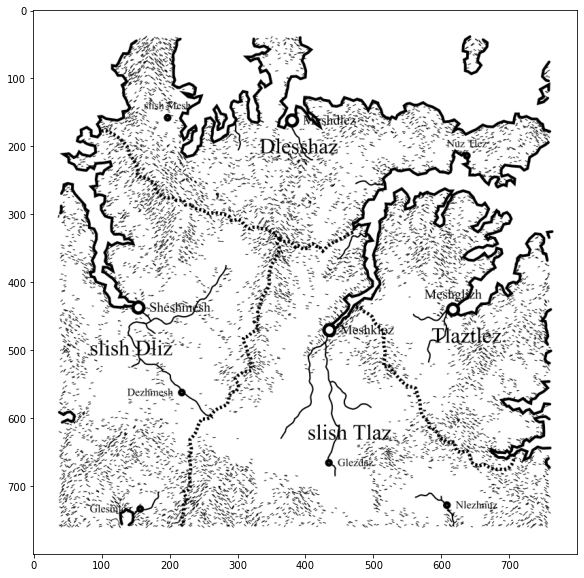

In [5]:
extractor.show()

In [6]:
drawing = extractor.coast()

In [7]:
extractor = SVGExtractor(f"../svgs/{realm_number}.svg", scale=config.svg.scaling)
drawing = extractor.coast() # sets extractor internal state to coast and returns a drawing

In [8]:
drawing.contents[0].contents

In [9]:
# heuristic 1: how many Groups are in the shape group?
# if there is more than 1, there are likely islands and stuff

In [10]:
drawing.contents[0].contents[0].contents[0].__dict__

{'fillColor': None,
 'fillOpacity': 1.0,
 'strokeColor': Color(0,0,0,1),
 'strokeWidth': 1.0,
 'strokeLineCap': 1,
 'strokeLineJoin': 0,
 'strokeMiterLimit': 0,
 'strokeDashArray': None,
 'strokeOpacity': 1.0,
 'points': [-8.636,
  -449.48499999999996,
  -9.017,
  -446.52599999999995,
  -8.874,
  -443.402,
  -6.864,
  -436.34000000000003,
  4.229,
  -431.733,
  11.27,
  -427.01,
  5.619,
  -421.647,
  -1.2599999999999998,
  -417.72099999999995,
  -5.239,
  -406.568,
  -1.8709999999999998,
  -399.931,
  1.4729999999999999,
  -388.22299999999996,
  0.606,
  -376.339,
  -8.161,
  -373.471,
  -15.713999999999999,
  -378.062,
  -25.163999999999998,
  -377.554,
  -30.566,
  -367.423,
  -31.636999999999997,
  -356.897,
  -33.673,
  -349.252,
  -35.355,
  -340.06199999999995,
  -44.195,
  -332.18199999999996,
  -33.234,
  -319.779,
  -38.798,
  -307.72299999999996,
  -46.605999999999995,
  -298.928,
  -48.796,
  -286.74399999999997,
  -37.934999999999995,
  -283.148,
  -31.154999999999998,
  -

In [11]:
drawing.contents[0].contents[0].contents[0].fillColor=drawing.contents[0].contents[0].contents[0].strokeColor

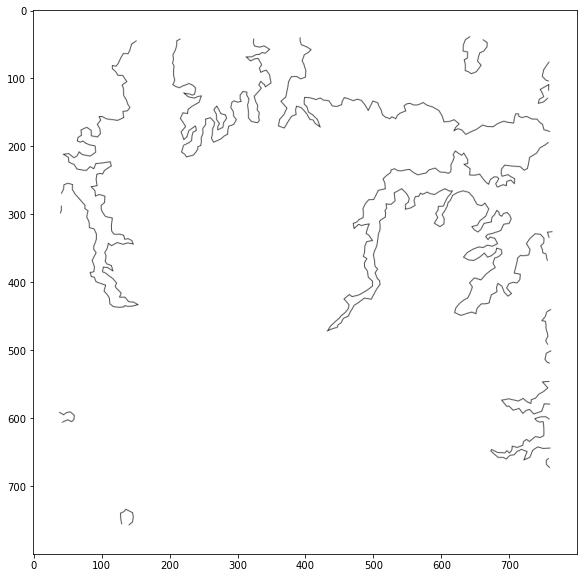

In [12]:
extractor.show()

In [53]:
paths = drawing.contents[0].contents[0].contents

arrays = []
for shape_group in drawing.contents[0].contents:
    path = shape_group.contents[0]
    plen = len(path.points)
    split_array = [[path.points[x],path.points[x+1]] for x in range(0,plen,2)]
    np_array = np.array(split_array)
    if len(np_array>3):
        arrays.append(np_array)


In [54]:
al = np.vstack(arrays)
import matplotlib.pyplot as plt

(-500.0, 500.0)

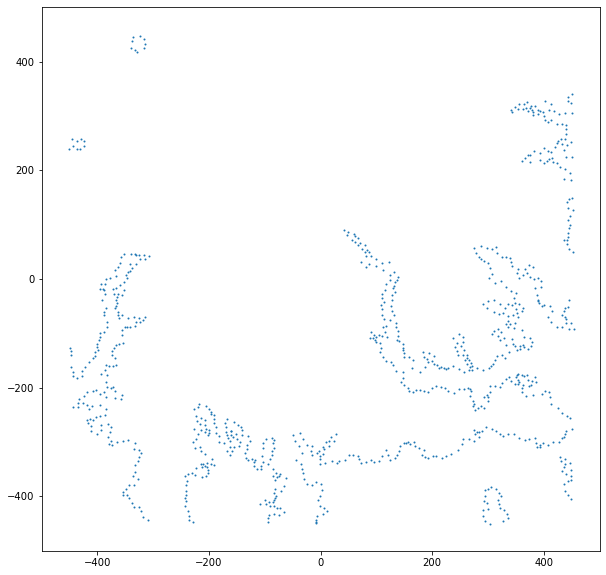

In [55]:
plt.figure(figsize=(10,10))
plt.scatter(al[:,0], al[:,1], s=1)
plt.xlim(-500,500)
plt.ylim(-500,500)

In [56]:
# what are all the end points?
begends = []
begends_list = []
for a in arrays:
    begends.append({
        "beg": a[0],
        "end": a[-1],
    })
    begends_list.append(a[0])
    begends_list.append(a[-1])
begends

[{'beg': array([  -8.636, -449.485]), 'end': array([ 450.28 , -276.626])},
 {'beg': array([-229.039, -446.703]), 'end': array([ -94.017, -447.074])},
 {'beg': array([ 303.395, -451.05 ]), 'end': array([ 327.139, -445.561])},
 {'beg': array([-309.634, -443.567]), 'end': array([-447.868, -162.478])},
 {'beg': array([ 448.901, -404.677]), 'end': array([ 447.898, -369.689])},
 {'beg': array([ 447.953, -352.011]), 'end': array([ 446.439, -338.11 ])},
 {'beg': array([-160.438, -279.617]), 'end': array([-160.438, -279.617])},
 {'beg': array([ 447.542, -256.592]), 'end': array([445.467, -39.298])},
 {'beg': array([-448.094, -140.009]), 'end': array([-449.583, -126.375])},
 {'beg': array([454.614, -92.658]), 'end': array([448.893, -81.486])},
 {'beg': array([451.989,  50.376]), 'end': array([446.155, 115.053])},
 {'beg': array([452.299, 126.505]), 'end': array([449.662, 149.199])},
 {'beg': array([449.128, 182.895]), 'end': array([450.309, 224.568])},
 {'beg': array([-446.519,  258.025]), 'end'

In [57]:
rng = 448
magnet = 10

In [58]:
begends_list = [
    a for a in begends_list
    if rng-magnet < abs(a[0]) < rng+magnet or rng-magnet < abs(a[1]) < rng+magnet
]

In [59]:
begends_list

[array([  -8.636, -449.485]),
 array([ 450.28 , -276.626]),
 array([-229.039, -446.703]),
 array([ -94.017, -447.074]),
 array([ 303.395, -451.05 ]),
 array([ 327.139, -445.561]),
 array([-309.634, -443.567]),
 array([-447.868, -162.478]),
 array([ 448.901, -404.677]),
 array([ 447.898, -369.689]),
 array([ 447.953, -352.011]),
 array([ 446.439, -338.11 ]),
 array([ 447.542, -256.592]),
 array([445.467, -39.298]),
 array([-448.094, -140.009]),
 array([-449.583, -126.375]),
 array([454.614, -92.658]),
 array([448.893, -81.486]),
 array([451.989,  50.376]),
 array([446.155, 115.053]),
 array([452.299, 126.505]),
 array([449.662, 149.199]),
 array([449.128, 182.895]),
 array([450.309, 224.568]),
 array([-446.519,  258.025]),
 array([-451.784,  239.399]),
 array([449.322, 252.141]),
 array([450.917, 305.162]),
 array([447.79 , 324.134]),
 array([449.629, 341.086]),
 array([-323.825,  446.677]),
 array([-336.584,  445.126])]

In [60]:
lefts = [
    a for a in begends_list
    if -rng-magnet < a[0] < -rng+magnet
]
lefts.sort(key=lambda x: -x[1])
lefts

[array([-446.519,  258.025]),
 array([-451.784,  239.399]),
 array([-449.583, -126.375]),
 array([-448.094, -140.009]),
 array([-447.868, -162.478])]

In [61]:
bottoms = [
    a for a in begends_list
    if -rng-magnet < a[1] < -rng+magnet
]
bottoms.sort(key=lambda x: x[0])
bottoms

[array([-309.634, -443.567]),
 array([-229.039, -446.703]),
 array([ -94.017, -447.074]),
 array([  -8.636, -449.485]),
 array([ 303.395, -451.05 ]),
 array([ 327.139, -445.561])]

In [62]:
rights = [
    a for a in begends_list
    if rng-magnet < a[0] < rng+magnet
]
rights.sort(key=lambda x: x[1])
rights

[array([ 448.901, -404.677]),
 array([ 447.898, -369.689]),
 array([ 447.953, -352.011]),
 array([ 446.439, -338.11 ]),
 array([ 450.28 , -276.626]),
 array([ 447.542, -256.592]),
 array([454.614, -92.658]),
 array([448.893, -81.486]),
 array([445.467, -39.298]),
 array([451.989,  50.376]),
 array([446.155, 115.053]),
 array([452.299, 126.505]),
 array([449.662, 149.199]),
 array([449.128, 182.895]),
 array([450.309, 224.568]),
 array([449.322, 252.141]),
 array([450.917, 305.162]),
 array([447.79 , 324.134]),
 array([449.629, 341.086])]

In [63]:
tops = [
    a for a in begends_list
    if rng-magnet < a[1] < rng+magnet
]
tops.sort(key=lambda x: -x[0])
tops

[array([-323.825,  446.677]), array([-336.584,  445.126])]

In [70]:
# start in left upper corner
lines = []

up_left = np.array([-rng, rng])
bottom_left = np.array([-rng, -rng])
bottom_right = np.array([rng, -rng])
up_right = np.array([rng, rng])
draw = True

now = up_left
# go down from the left side
for co in lefts:
    if draw:
        lines.append([now, co])
        draw = False
    elif not draw:
        now = co
        draw = True
        
if draw:
    lines.append([now, bottom_left])
    now = bottom_left
# go right at the bottom
for co in bottoms:
    if draw:
        lines.append([now, co])
        draw = False
    elif not draw:
        now = co
        draw = True
        
if draw:
    lines.append([now, bottom_right])
    now = bottom_right
# go up at the right
for co in rights:
    if draw:
        lines.append([now, co])
        draw = False
    elif not draw:
        now = co
        draw = True
        
if draw:
    lines.append([now, up_right])
    now = up_right
# go left at the top
for co in tops:
    if draw:
        lines.append([now, co])
        draw = False
    elif not draw:
        now = co
        draw = True
        
if draw:
    lines.append([now, up_left])

In [71]:
lines

[[array([-448,  448]), array([-446.519,  258.025])],
 [array([-451.784,  239.399]), array([-449.583, -126.375])],
 [array([-448.094, -140.009]), array([-447.868, -162.478])],
 [array([-309.634, -443.567]), array([-229.039, -446.703])],
 [array([ -94.017, -447.074]), array([  -8.636, -449.485])],
 [array([ 303.395, -451.05 ]), array([ 327.139, -445.561])],
 [array([ 448.901, -404.677]), array([ 447.898, -369.689])],
 [array([ 447.953, -352.011]), array([ 446.439, -338.11 ])],
 [array([ 450.28 , -276.626]), array([ 447.542, -256.592])],
 [array([454.614, -92.658]), array([448.893, -81.486])],
 [array([445.467, -39.298]), array([451.989,  50.376])],
 [array([446.155, 115.053]), array([452.299, 126.505])],
 [array([449.662, 149.199]), array([449.128, 182.895])],
 [array([450.309, 224.568]), array([449.322, 252.141])],
 [array([450.917, 305.162]), array([447.79 , 324.134])],
 [array([449.629, 341.086]), array([448, 448])],
 [array([448, 448]), array([-323.825,  446.677])],
 [array([-336.584

(-500.0, 500.0)

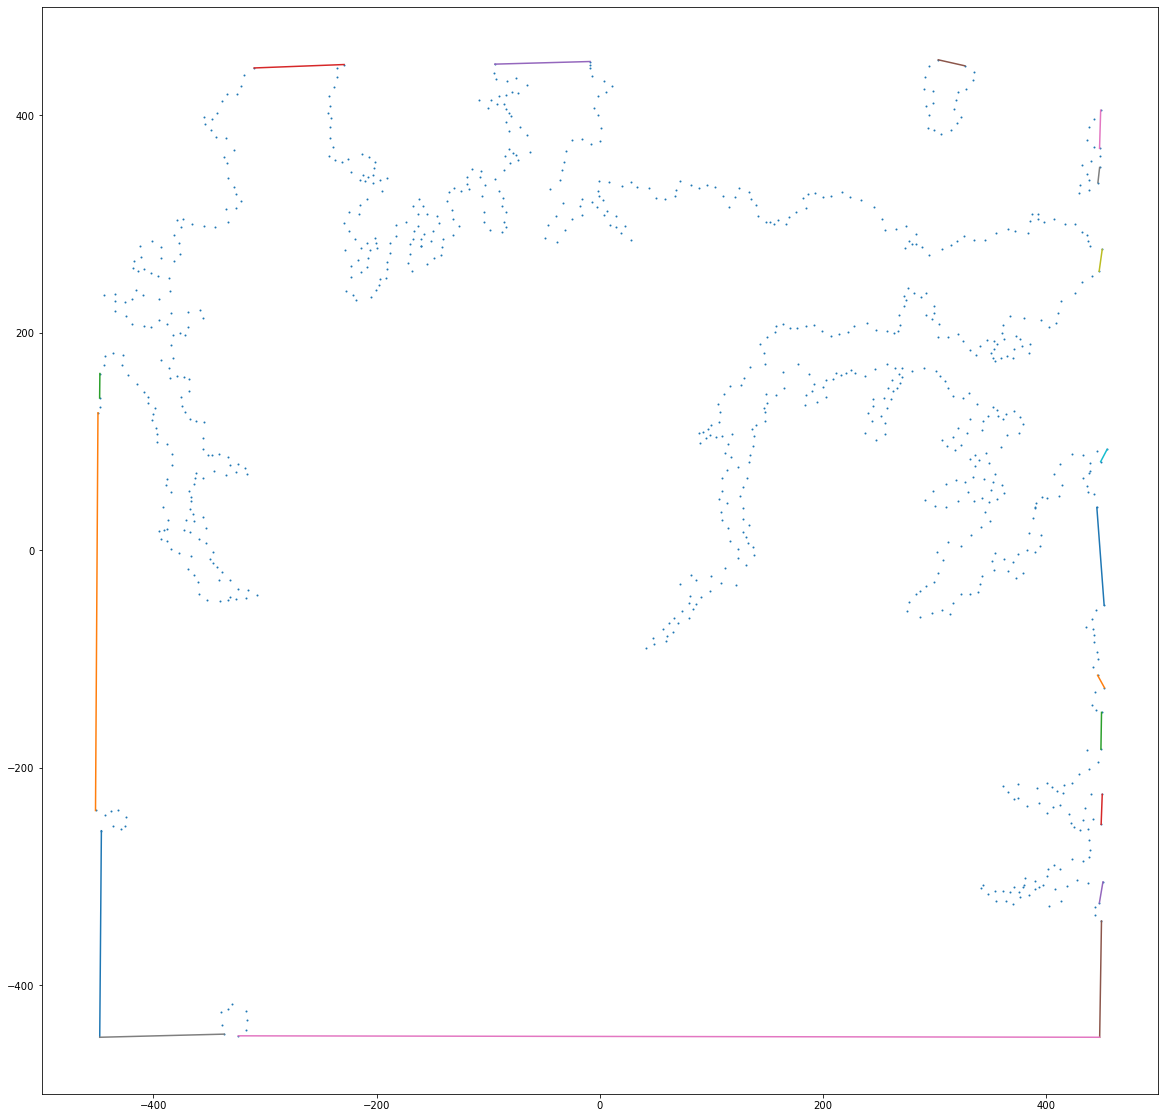

In [72]:
plt.figure(figsize=(20,20))
plt.scatter(al[:,0], -al[:,1], s=1)
for line in lines:
    plt.plot(np.vstack(line)[:,0], -np.vstack(line)[:,1])
plt.xlim(-500,500)
plt.ylim(-500,500)